<a href="https://colab.research.google.com/github/Clint07-datascientist/ML_Pipeline_Summative/blob/main/notebook/ml_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!git clone https://github.com/Clint07-datascientist/ML_Pipeline_Summative.git

Cloning into 'ML_Pipeline_Summative'...
remote: Enumerating objects: 20717, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 20717 (delta 9), reused 24 (delta 5), pack-reused 20681 (from 3)
Receiving objects: 100% (20717/20717), 1.24 GiB | 36.47 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (24563/24563), done.


In [7]:
# Importing all necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix


In [8]:
# Dataset structure: data/train/<class_name>/*.jpg and data/test/<class_name>/*.jpg
train_dir = "/content/ML_Pipeline_Summative/data/train_set"
test_dir = "/content/ML_Pipeline_Summative/data/test_set"

classes = ['fall_armyworm', 'grasshopper', 'healthy', 'leaf_beetle',
           'leaf_blight', 'leaf_spot', 'streak_virus']

IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 10

In [9]:
# Data Generators
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 19426 images belonging to 7 classes.
Found 5125 images belonging to 7 classes.


In [10]:
# Defining the model
base_model = MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)
base_model.trainable = False  # Freeze base

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(classes), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,855 (9.24 MB)

 Trainable params: 164,871 (644.03 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [11]:
# Model Training
history = model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=EPOCHS
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
608/608 ━━━━━━━━━━━━━━━━━━━━ 1251s 2s/step - accuracy: 0.6049 - loss: 1.0628 - val_accuracy: 0.7056 - val_loss: 0.7167
Epoch 2/10
608/608 ━━━━━━━━━━━━━━━━━━━━ 1297s 2s/step - accuracy: 0.7348 - loss: 0.6904 - val_accuracy: 0.7284 - val_loss: 0.6625
Epoch 3/10
608/608 ━━━━━━━━━━━━━━━━━━━━ 1232s 2s/step - accuracy: 0.7466 - loss: 0.6531 - val_accuracy: 0.7387 - val_loss: 0.6275
Epoch 4/10
608/608 ━━━━━━━━━━━━━━━━━━━━ 1224s 2s/step - accuracy: 0.7517 - loss: 0.6219 - val_accuracy: 0.7309 - val_loss: 0.6369
Epoch 5/10
608/608 ━━━━━━━━━━━━━━━━━━━━ 1227s 2s/step - accuracy: 0.7713 - loss: 0.6003 - val_accuracy: 0.7362 - val_loss: 0.6352
Epoch 6/10
608/608 ━━━━━━━━━━━━━━━━━━━━ 1252s 2s/step - accuracy: 0.7673 - loss: 0.5911 - val_accuracy: 0.7397 - val_loss: 0.6079
Epoch 7/10
608/608 ━━━━━━━━━━━━━━━━━━━━ 1234s 2s/step - accuracy: 0.7736 - loss: 0.5707 - val_accuracy: 0.7460 - val_loss: 0.5998
Epoch 8/10
608/608 ━━━━━━━━━━━━━━━━━━━━ 1227s 2s/step - accuracy: 0.7775 - loss: 0.5632 - 

In [12]:
# Saving the model
model.save("/content/ML_Pipeline_Summative/models/maize_model.h5")


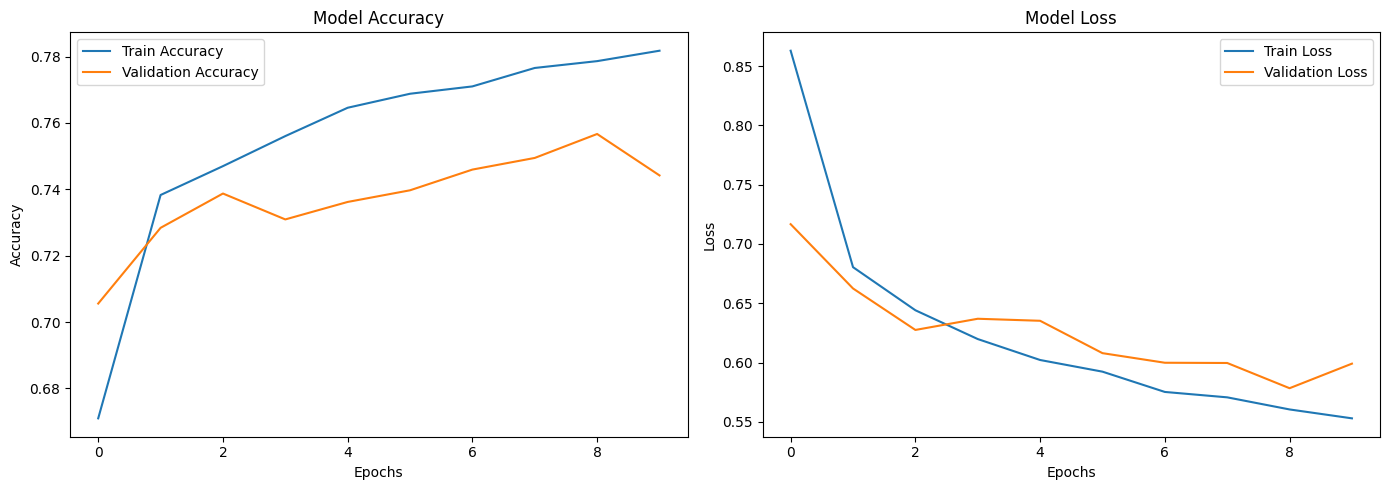

In [13]:
# Plot accruracy and loss
plt.figure(figsize=(14, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


161/161 ━━━━━━━━━━━━━━━━━━━━ 217s 1s/step
               precision    recall  f1-score   support

fall armyworm       0.90      0.66      0.76       284
   grasshoper       0.84      0.94      0.89       411
      healthy       0.53      0.87      0.66       211
  leaf beetle       0.92      0.94      0.93       950
  leaf blight       0.62      0.76      0.68      1004
    leaf spot       0.73      0.43      0.54      1261
 streak virus       0.74      0.86      0.79      1004

     accuracy                           0.74      5125
    macro avg       0.75      0.78      0.75      5125
 weighted avg       0.75      0.74      0.73      5125



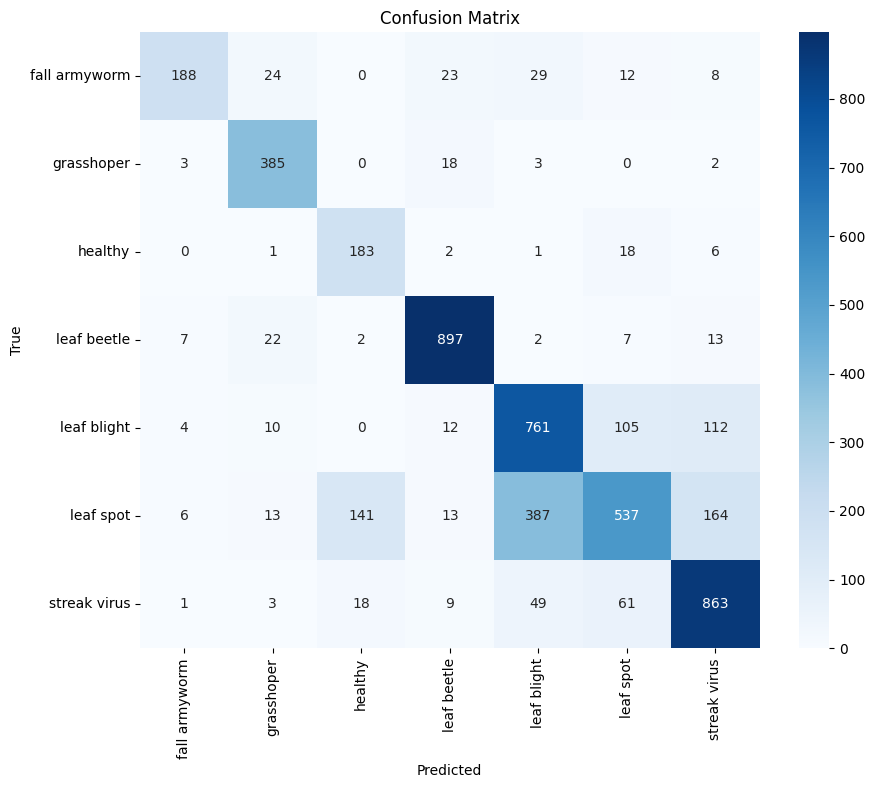

In [14]:
# Evaluating the model using confucion matrix
predictions = model.predict(test_gen)
y_pred = np.argmax(predictions, axis=1)
y_true = test_gen.classes
label_names = list(test_gen.class_indices.keys())

print(classification_report(y_true, y_pred, target_names=label_names))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_names, yticklabels=label_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [ ]:
# Predicting on a single image
from tensorflow.keras.preprocessing import image

def predict_single(img_path):
    img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = image.img_to_array(img)
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    predicted_class = label_names[np.argmax(prediction)]
    confidence = np.max(prediction)

    plt.imshow(img)
    plt.title(f"Prediction: {predicted_class} ({confidence:.2f})")
    plt.axis("off")
    plt.show()

# Example
predict_single("../data/test/leaf_blight/sample.jpg")
